In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from feature_engine.imputation import CategoricalImputer, DropMissingData
from feature_engine.encoding import RareLabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from feature_engine.wrappers import SklearnTransformerWrapper
from catboost import CatBoostClassifier
import optuna
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pickle
import random 
import warnings

warnings.filterwarnings(action='ignore')

### Load Data

In [2]:
with open('models/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('models/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('models/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('models/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)


# get columns 
columns_original = X_train.columns
cat_cols = X_train.iloc[:,[1, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]].columns


In [3]:
X_train.head(1)

,amount_tsh,funder,gps_height,installer,basin,region,population,public_meeting,scheme_management,permit,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_class,waterpoint_type_group,age
5974,0.0,Government Of Tanzania,1410,DWE,Pangani,Arusha,200,True,VWC,True,gravity,user-group,unknown,good,enough,groundwater,communal standpipe,43.284932


### Load Models

In [4]:
with open('models/xgb_preprocessing.pkl', 'rb') as f:
    pipeline_xgb = pickle.load(f)

with open('models/xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

In [5]:
pipeline_xgb

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_transformer',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [1, 3, 4, 5, 7, 8, 9, 10, 11,
                                                   12, 13, 14, 15, 16]),
                                                 ('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 2, 6, 17])]))])

In [6]:
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.670726369939647, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.65297307591977, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.18903976053222393,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

### 

In [7]:
# preprocess data
X_train = pipeline_xgb.fit_transform(X_train)
X_test = pipeline_xgb.transform(X_test)

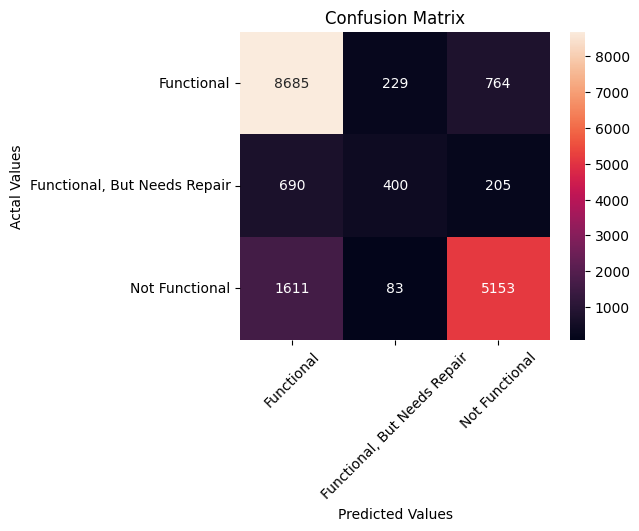

In [24]:
# generate predictions
y_pred = xgb_model.predict(X_test)

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
labels = ['Functional', 'Functional, But Needs Repair', 'Not Functional']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.xticks(rotation=45)
plt.show()